## Questions

In [7]:

import sys
sys.path.append('..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from src.classical_tracker import ClassicalTracker
from src.features import compute_gradients, visualize_gradients, visualize_gradient_magnitude

VIDEO_PATH_MUG = '../Test-Videos/Antoine_Mug.mp4'
VIDEO_PATH_BALL='../Test-Videos/VOT-ball.mp4'

### 1. Meanshift
q1. Experiment the tracking performed by the provided code Tracking_MeanShift.py that uses the
basic Mean Shift algorithm, on the marginal density of the hue comp onent H. Explain the principle
of this algorithm, and illustrate its advantages and limits by your exp eriments.

In [ ]:
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue'
)
tracker.track_video(visualize=True, save_result=True, output_dir='../results/q1_basic')

Step 1: Select ROI
Step 2: Initialize tracker
Mean Shift initialized with hue histogram
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

Tracking stopped by user

✅ Tracking completed. Total frames: 43


Q2 Analyse more in-depth the result by displaying the sequences of hue images, and also the
weight images corresp onding to the back-pro jection of the hue histogram. Prop ose and program
improvements, by changing the computed density and/or up dating the mo del histogram.

In [ ]:
#analysis
tracker = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue'
)

tracker.track_video(
    visualize=True,
    visualize_process=True,  # ✅ 这个参数会调用 visualize_hue_and_backprojection
    save_result=True,
    output_dir='../results/q2_analysis'
)

Step 1: Select ROI
Step 2: Initialize tracker
Mean Shift initialized with hue histogram
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


In [ ]:
# 改进1 - 双通道直方图
print("=== Q2 Improvement 1: Dual-Channel Histogram (H+S) ===")
print("Why: Single Hue may confuse similar colors")
print("Solution: Use Hue + Saturation for better discrimination")

tracker_dual = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hsv'  # 改用双通道
)

tracker_dual.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_dual_channel'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 1: Dual-Channel Histogram (H+S) ===
Why: Single Hue may confuse similar colors
Solution: Use Hue + Saturation for better discrimination
Step 1: Select ROI
Step 2: Initialize tracker
Mean Shift initialized with hsv histogram
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


In [ ]:
# Cell: Q2 改进2 - 模型更新
print("=== Q2 Improvement 2: Adaptive Model Update ===")
print("Why: Object appearance changes (lighting, pose)")
print("Solution: Gradually update histogram model over time")

tracker_adaptive = ClassicalTracker(
    video_path=VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hue',
    update_model=True,     # ✅ 启用模型更新
    update_rate=0.05       # 5% new, 95% old
)

tracker_adaptive.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_adaptive'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 2: Adaptive Model Update ===
Why: Object appearance changes (lighting, pose)
Solution: Gradually update histogram model over time
Step 1: Select ROI
Step 2: Initialize tracker
Mean Shift initialized with hue histogram
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


In [ ]:
# Cell: Q2 改进3 - 组合
print("=== Q2 Improvement 3: Combined Approach ===")
print("Using both H+S channels AND adaptive update")

tracker_combined = ClassicalTracker(
    video_path= VIDEO_PATH_MUG,
    method='meanshift',
    color_space='hsv',     # ✅ 双通道
    update_model=True,     # ✅ 模型更新
    update_rate=0.05
)

tracker_combined.track_video(
    visualize=True,
    save_result=True,
    output_dir='../results/q2_combined'
)

import cv2
cv2.destroyAllWindows()

=== Q2 Improvement 3: Combined Approach ===
Using both H+S channels AND adaptive update
Step 1: Select ROI
Step 2: Initialize tracker
Mean Shift initialized with hsv histogram
Step 3: Start tracking
Press 's' to save frame, 'ESC' to exit

✅ Tracking completed. Total frames: 221


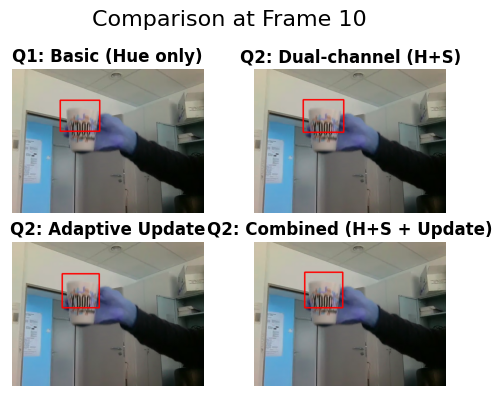

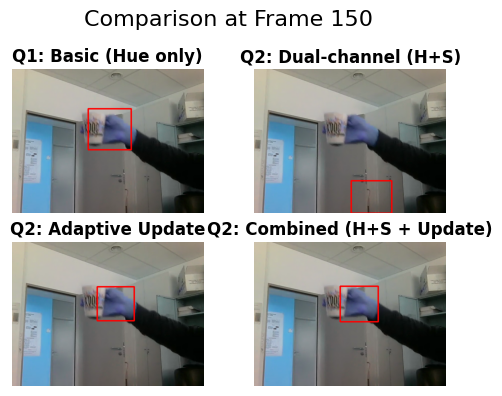

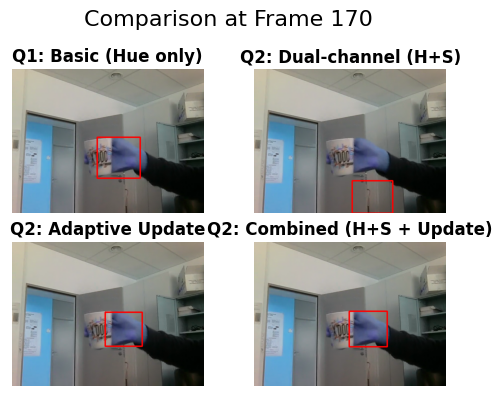

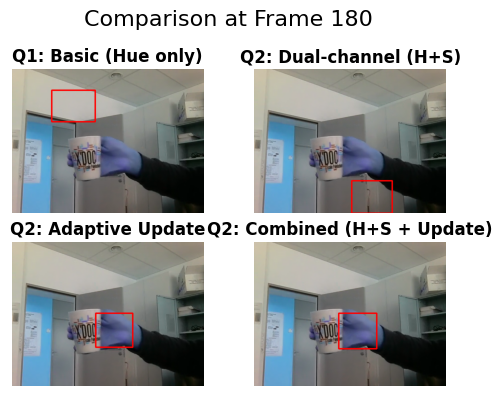

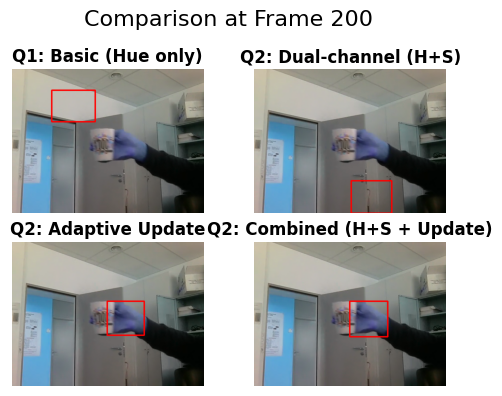

In [ ]:
# 对比mean-shift所有方法
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

methods = [
    ('Q1: Basic (Hue only)', '../results/q1_basic'),
    ('Q2: Dual-channel (H+S)', '../results/q2_dual_channel'),
    ('Q2: Adaptive Update', '../results/q2_adaptive'),
    ('Q2: Combined (H+S + Update)', '../results/q2_combined')
]

# 选择几个关键帧对比
frame_numbers = [10,150,170,180, 200]

for frame_num in frame_numbers:
    fig, axes = plt.subplots(2, 2, figsize=(5, 4))
    axes = axes.flatten()
    
    for ax, (name, path) in zip(axes, methods):
        frame_path = f"{path}/Frame_{frame_num:04d}.png"
        try:
            img = Image.open(frame_path)
            ax.imshow(np.array(img)[:,:,::-1])  # BGR to RGB
            ax.set_title(name, fontsize=12, fontweight='bold')
            ax.axis('off')
        except:
            ax.text(0.5, 0.5, f'Frame not found\n{name}', 
                   ha='center', va='center')
            ax.axis('off')
    
    plt.suptitle(f'Comparison at Frame {frame_num}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'../results/q2_comparison_frame_{frame_num}.png', dpi=150)
    plt.show()

### 2. Hough Transform
Q3 Calculate for each frame, the lo cal orientation, i.e. the gradient argument of pixels, and also
the gradient magnitude. Use a threshold on the gradient magnitude to mask pixels whose orientation
is not signinficant. Display the sequence of orientations, where the masked pixels app ear in red. One
example of expected result is shown on Figure 1.
1
